In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np 
from vqls import *
from utils import *
from sklearn.metrics import mean_squared_error
import matplotlib.lines as mlines


## getting the datasets

In [2]:
pnq = {'3':(3,8),
        '4':(4,16)}
gqs = {}
func_dict, func_out, lower, upper = get_func('gqs')
for flab, fun in func_out.items():
    for nq, knot in  pnq.values():
        file_path = f"results/results_gvqs_{flab}_{nq}.json"
        df = pd.read_json(file_path).drop(['Condition number', 'norm(yk)', 'training_cost', 'exe_time','RSS_h'], axis =1 )
        tmp = []
        for el in df["in_train_weights"]:
             tmp.append(el[-1])
        df["weights"] = tmp
        df = df.drop(["in_train_weights", 'RSS_q'], axis = 1)
        gqs[f"{flab}{nq}"] = df 

In [3]:
vqs = {}
func_dict, func_out, lower, upper = get_func('vqs')
for flab, fun in func_out.items():
    if flab in [ 'elu', 'sin', 'relu', 'sigmoid']:
        for stp in [20]:
            file_path = f'results/results_vqs_{flab}_1_{stp}.json'
            df = pd.read_json(file_path).drop(['training_cost', 'rmse', 'exe_time','RSS_q'], axis =1 )
            tmp = []
            vqs[f"{flab}{stp}"] = df 

## Best models vqs

In [4]:
func_dict, func_out, lower, upper = get_func('vqs')
nq = 1
n_step = 20 
step = (upper-lower)/n_step
x = np.arange(lower, upper, step).tolist()
from utils import *
best=[]
a= []
for k, el in vqs.items():
    #function dependant 
    flab = k[:-2]
    func = func_out[flab]
    f_i = func_dict[flab]
    y = [func(value,f_i) for value in x]
    metrics = []
    yfq= []
    #model dependant
    for i, model in el.iterrows():
        qprod = qProduct(1)
        qc_full = []
        for j in range(len(x)):
            point = [1,x[j]]
            qc_full.append(qprod.direct_prod2(model.weights[j],point).item())  
        yfq.append(qc_full)
        metrics.append(mean_squared_error(y,qc_full)/(np.max(y)-np.min(y)))
    tmp = el.iloc[np.argmin(metrics)]
    a.append(qc_full)
    tmp['nrmse'] = np.min(metrics)
    tmp['flab'] = flab
    tmp['y_q'] = yfq[np.argmin(metrics)]
    tmp['knots'] = n_step
    best.append(tmp)
vqs_best = pd.DataFrame([a for a in best]).reset_index(drop=True)


In [5]:
vqs_best

,weights,seed,nrmse,flab,y_q,knots
0,"[[6.084102], [-0.098898], [-0.010412], [0.0738...","[1795, 3887, 161, 694, 5335, 7020, 4029, 8615,...",0.006699,sigmoid,"[-0.09937734958892708, 0.10185511890259918, 0....",20
1,"[[2.6933591274], [2.4721908364000003], [2.2612...","[7508, 9619, 9073, 8902, 9844, 3185, 6157, 833...",0.127772,elu,"[-0.9749907825940822, -0.9259382502098983, -0....",20
2,"[[6.3918571595], [6.4884885106], [6.5078300921...","[8664, 8583, 7761, 8372, 3949, 793, 4849, 3424...",0.006927,relu,"[0.054309193273299194, 0.05004762359521847, 0....",20
3,"[[0.11290934300000001], [6.2775850912], [6.215...","[9262, 3259, 3251, 1237, 5605, 8709, 8222, 491...",0.067675,sin,"[-0.05642468821618646, -0.055354861185012816, ...",20


## Best model gqs

In [6]:
func_dict, func_out, lower, upper = get_func('gqs')
pnq = {'3':(3,8),
        '4':(4,16)}


best=[]

for k, el in gqs.items():
    #function dependant 
    nq, n_step = pnq[k[-1]]
    flab = k[:-1]
    func = func_out[flab]
    f_i = func_dict[flab]

    x = np.arange(lower, upper + .03, (upper-lower)/n_step).tolist() 
    xx = np.linspace(lower, upper, n_step) ##inputs sampling in the interval 0,1

    metrics = []
    #model dependant
    matrix,vector,v_norm = GeneralizedVQS_System(n_step,flab,x,xx)
    yfq = []
    for i, model in el.iterrows():
        qprod = qProduct(nq)
        y_fq=[]
        for j, k in enumerate(matrix):
            y_fq.append(qprod.direct_prod2(model.weights,k,visualize=False))
        metrics.append(mean_squared_error(v_norm,y_fq)/(np.max(v_norm)-np.min(v_norm)))
        yfq.append(y_fq)
        
    tmp = el.iloc[np.argmin(metrics)]
    tmp['nrmse'] = np.min(metrics)
    tmp['flab'] = flab 
    tmp['y_q'] = yfq[np.argmin(metrics)]
    tmp['knots'] = n_step

    best.append(tmp)
gqs_best = pd.DataFrame([a for a in best]).reset_index(drop=True)


In [7]:
gqs_best

,seed,weights,nrmse,flab,y_q,knots
0,28,"[2.7451074065, 2.6239581654, 0.002763550600000...",0.028781,sigmoid,"[-0.012895723006044895, 0.055394373950103715, ...",8
1,7,"[1.5756719111000002, 3.1864332824, 3.007082071...",0.015558,sigmoid,"[0.009504337798492201, 0.011645921583844778, 0...",16
2,12,"[-0.0113545294, 2.6037647359, 0.68391100550000...",0.030278,elu,"[0.043698036127126874, 0.07012877804653342, 0....",8
3,16,"[-0.07634497850000001, 2.9311705934, 1.3387460...",0.012593,elu,"[0.01242582988170683, 0.019090526632298557, 0....",16
4,65,"[0.7319219738, -0.0611252719, 0.5035409995, 1....",0.032586,relu,"[0.011697345144396694, 0.013349264683715842, -...",8
5,4463,"[0.5459834437000001, 4.5067929968, 3.114206035...",0.011067,relu,"[-0.0065359910877973645, -0.00822789641868585,...",16
6,46,"[3.5623727854, 2.2885923806, 0.9213463521, 2.7...",0.020795,sin,"[0.2648643341229378, 0.6161577411597742, 0.694...",8
7,96,"[0.5486421942, 2.5420301889, 3.0675882172, 2.9...",0.009882,sin,"[0.2346884467841766, 0.2896004253168862, 0.405...",16


In [8]:
#vqs_best.drop(1, inplace=True)
vqs_best

,weights,seed,nrmse,flab,y_q,knots
0,"[[6.084102], [-0.098898], [-0.010412], [0.0738...","[1795, 3887, 161, 694, 5335, 7020, 4029, 8615,...",0.006699,sigmoid,"[-0.09937734958892708, 0.10185511890259918, 0....",20
1,"[[2.6933591274], [2.4721908364000003], [2.2612...","[7508, 9619, 9073, 8902, 9844, 3185, 6157, 833...",0.127772,elu,"[-0.9749907825940822, -0.9259382502098983, -0....",20
2,"[[6.3918571595], [6.4884885106], [6.5078300921...","[8664, 8583, 7761, 8372, 3949, 793, 4849, 3424...",0.006927,relu,"[0.054309193273299194, 0.05004762359521847, 0....",20
3,"[[0.11290934300000001], [6.2775850912], [6.215...","[9262, 3259, 3251, 1237, 5605, 8709, 8222, 491...",0.067675,sin,"[-0.05642468821618646, -0.055354861185012816, ...",20


# Visualize

## visualize vqs


0


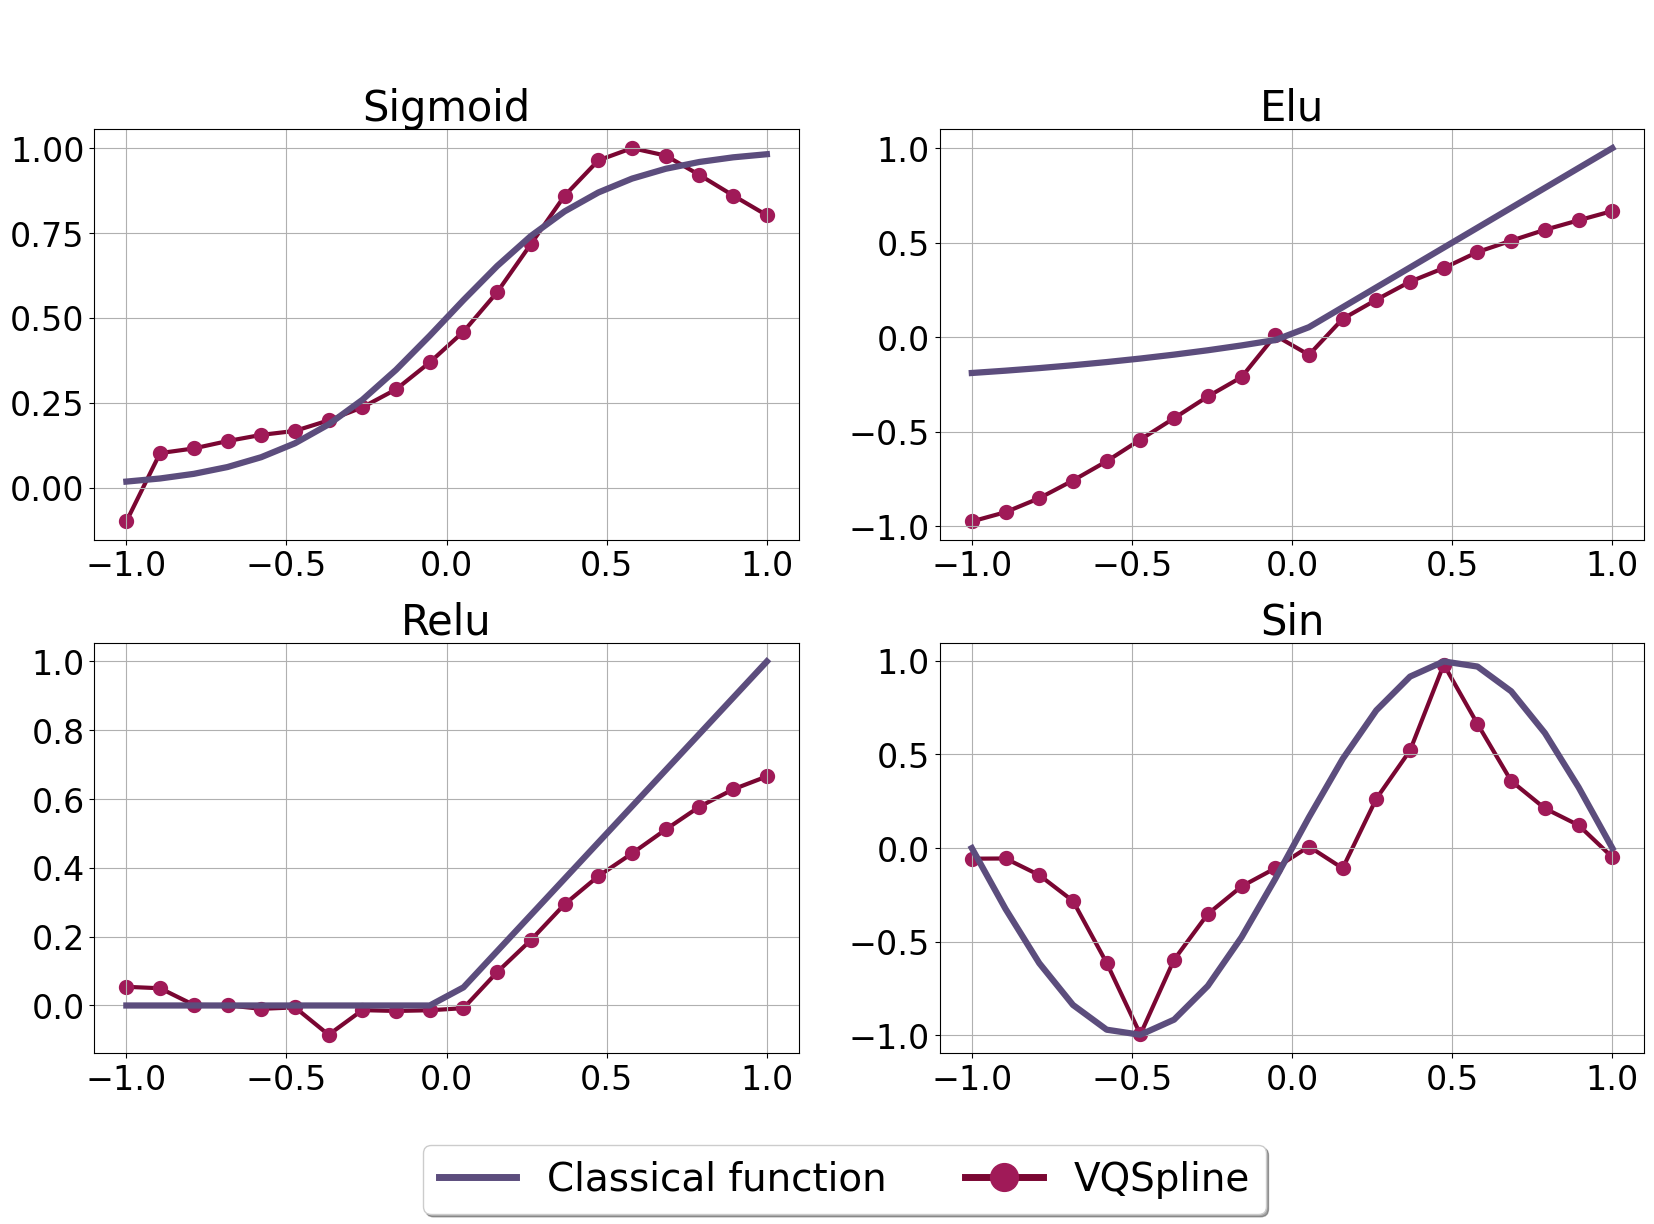

In [9]:
func_dict, func_out, lower, upper = get_func('vqs')

j = 0
k = 0
rss=[]
#FIG OPTION

fig = plt.figure(tight_layout = False, figsize=(20,12))
fig.tight_layout()
fig.suptitle('Figure title')
axE = fig.subfigures(1,1,)

fig.suptitle(f'{flab}',fontsize=36)

ax = axE.subplots(nrows=2, ncols=2, sharey=False,)
fig.subplots_adjust(hspace=0.25)
for i, el in vqs_best.iterrows():
    y_fq = el['y_q']    
    nq, n_step = 1, 20
    flab = el.flab
    func = func_out[flab]
    f_i = func_dict[flab]
    if(flab =='elu'):
        print(f_i)
    xx = np.linspace(lower, upper, n_step) ##inputs sampling in the interval 0,1
    y = [func(value,f_i) for value in xx]
    axa = ax[k][j] 
    axa.tick_params(axis='both', which='major', labelsize=24)
    axa.grid(zorder = -3)
    axa.plot(xx,y,  label=f"Original function scaled {n_step}", color = '#5c4d7d',linewidth=4.5)

    colorl = '#7a0632'
    colors = '#a01a58'
    axa.plot(xx,y_fq, color=colorl, zorder= -1, lw=3)
    axa.scatter(xx,(y_fq), color=colors, linewidths=5)
    #plt.scatter(np.linspace(lower,upper,len(y_fq)),(y_q), label= f"hq {n_step}", color='blue')
    #plt.plot(np.linspace(lower,upper,len(y_fq)),(y_q), label= f"hq {n_step}", color='blue')
    #ax[i].text(0.35,0.87, f"rmse scaled = {rssss2:.4f}\n" \
    #    f"rmse classical = {rssss:.4f}\n", fontsize=14)
    axa.set_title(f'{flab.capitalize()}',fontsize=30)
    j-=-1
    if(j%2==0):
        j = 0
        k -=-1
handles = [mlines.Line2D([], [], color='#5c4d7d', linewidth=5, label='Classical function')]
#handles.append(mlines.Line2D([], [], color='#1780a1', linewidth=5, label='classical spline'))
handles.append(mlines.Line2D([], [], color=colorl, marker='.',linewidth=5,
                    markersize=40, label='VQSpline', markerfacecolor=colors, markeredgecolor=colors))

lgd = axE.legend(handles = handles, loc='upper center', bbox_to_anchor=(0.5, 0.05),fancybox=True, shadow=True, ncol=5, fontsize = 28)



fig.savefig(f'plots/n_vqsplot.png', bbox_extra_artists=(lgd,), bbox_inches='tight')


## visualize gqs

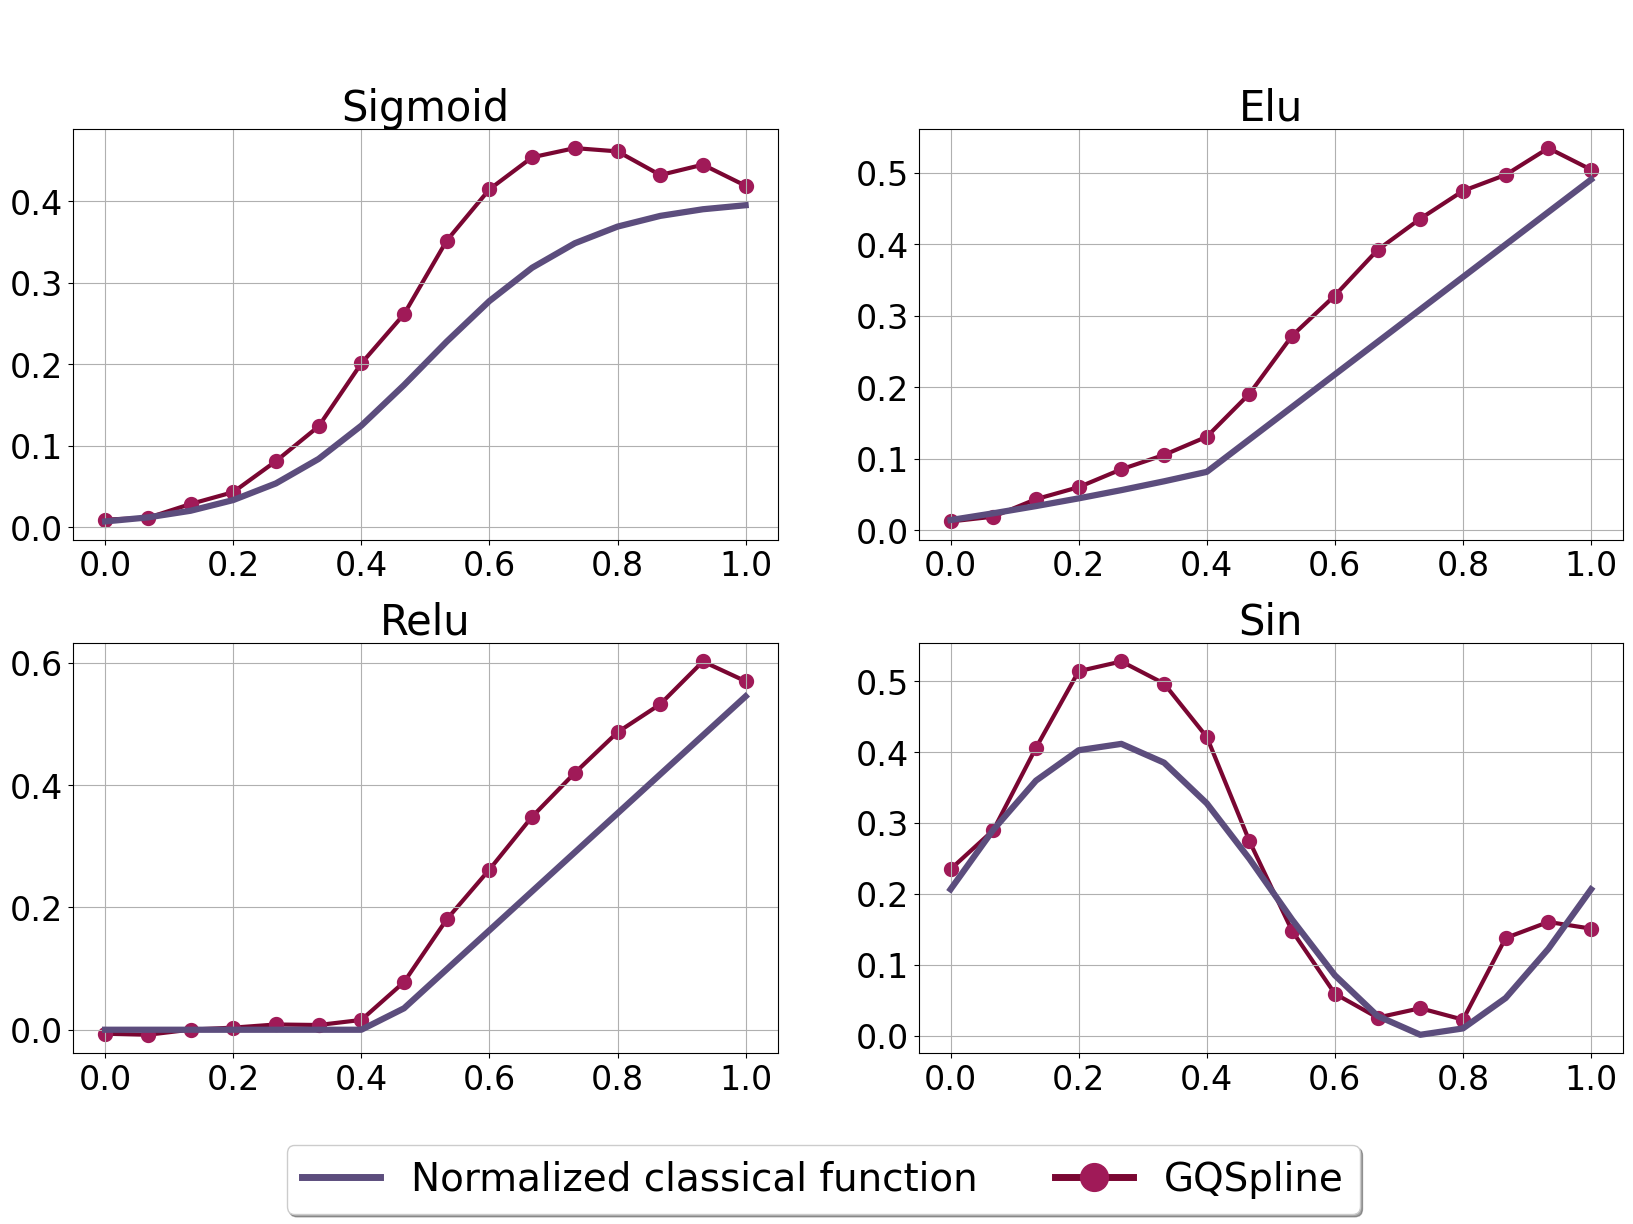

In [10]:
func_dict, func_out, lower, upper= get_func('gqs')
j = 0
k = 0
rss=[]

#FIG OPTION
fig = plt.figure(tight_layout = False, figsize=(20,12))
fig.tight_layout()
fig.suptitle('Figure title')
axE = fig.subfigures(1,1,)
fig.suptitle(f'{flab}',fontsize=36)
ax = axE.subplots(nrows=2, ncols=2, sharey=False,)
fig.subplots_adjust(hspace=0.25)

pnqrvrs = {'8':(3,8),
        '16':(4,16)}

#fig.subplots_adjust(hspace=1)

for i, el in gqs_best.iterrows():
    if el.knots==16:
        y_fq = el['y_q']    
        nq, n_step = pnqrvrs[str(el.knots)]
        flab = el.flab
        func = func_out[flab]
        f_i = func_dict[flab]
        xx = np.linspace(lower, upper, n_step) ##inputs sampling in the interval 0,1
        y = [func(value,f_i) for value in xx]
        norm = np.linalg.norm(y)
        y = y / norm

        axa = ax[k][j] 
        axa.tick_params(axis='both', which='major', labelsize=24)
        axa.grid(zorder = -3)
        ax[k][j].plot(xx,y,  label=f"Original function scaled {n_step}", color = '#5c4d7d',linewidth=4.5)

        colorl = '#7a0632'
        colors = '#a01a58'
        ax[k][j].plot(xx,y_fq, color=colorl, zorder= -1, lw=3)
        ax[k][j].scatter(xx,(y_fq), color=colors, linewidths=5)
        #plt.scatter(np.linspace(lower,upper,len(y_fq)),(y_q), label= f"hq {n_step}", color='blue')
        #plt.plot(np.linspace(lower,upper,len(y_fq)),(y_q), label= f"hq {n_step}", color='blue')
        #ax[i].text(0.35,0.87, f"rmse scaled = {rssss2:.4f}\n" \
        #    f"rmse classical = {rssss:.4f}\n", fontsize=14)
        ax[k][j].set_title(f'{flab.capitalize()}',fontsize=30)
        j-=-1
        if(j%2==0):
            j = 0
            k -=-1
handles = [mlines.Line2D([], [], color='#5c4d7d', linewidth=5, label='Normalized classical function')]
#handles.append(mlines.Line2D([], [], color='#1780a1', linewidth=5, label='classical spline'))
handles.append(mlines.Line2D([], [], color=colorl, marker='.',linewidth=5,
                    markersize=40, label='GQSpline', markerfacecolor=colors, markeredgecolor=colors))

lgd = axE.legend(handles = handles, loc='upper center', bbox_to_anchor=(0.5, 0.05),fancybox=True, shadow=True, ncol=5, fontsize = 28)


fig.savefig(f'plots/n_gvqsplot.png', bbox_extra_artists=(lgd,), bbox_inches='tight')



# Table

In [11]:
vqs_trim=vqs_best.drop(['weights','y_q','seed' ], axis=1)
vqs_trim['model'] = ['vqs' for _ in range(vqs_trim.shape[0])]

In [12]:
gqs_trim=gqs_best.drop(['weights','y_q','seed' ], axis=1)
gqs_trim['model'] = ['gqs' for _ in range(gqs_trim.shape[0])]

In [13]:
a = pd.concat([vqs_trim, gqs_trim])
a['model'] = a['model'].astype('category')
print(a.pivot(['model', 'knots'],['flab']))#.to_markdown(tablefmt='latex_raw'))

                nrmse                              
flab              elu      relu   sigmoid       sin
model knots                                        
gqs   8      0.030278  0.032586  0.028781  0.020795
      16     0.012593  0.011067  0.015558  0.009882
vqs   20     0.127772  0.006927  0.006699  0.067675


In [14]:
a.pivot(['model', 'knots'],['flab'])

nrmse                              
flab              elu      relu   sigmoid       sin
model knots                                        
gqs   8      0.030278  0.032586  0.028781  0.020795
      16     0.012593  0.011067  0.015558  0.009882
vqs   20     0.127772  0.006927  0.006699  0.067675